In [48]:
from rpy2 import robjects
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime
import yaml
import os

# Convert pandas dataframe
from rpy2.robjects import pandas2ri
pandas2ri.activate()

output_dir = 'output_12-20-2gamma/'
#output_dir = 'output_12-10-gammaI/'

dept_avail = os.listdir(output_dir)


rainfall = pd.read_csv('haiti-data/fromAzman/rainfall.csv', index_col = 0, parse_dates = True)
cases    = pd.read_csv('haiti-data/fromAzman/cases_corrected.csv', index_col=0, parse_dates =True)


compartments = ['S', 'I', 'A', 'RA1', 'RA2', 'RA3', 'RI1', 'RI2', 'RI3', 'W', 'B', 'cases']

stream = open('haiti-data/input_parameters.yaml', 'r')
input_parameters = yaml.load(stream)

dept_name = [list(pop.keys())[0] for pop in input_parameters['population']]

t_start = input_parameters['t_start']
t_for = datetime.date(2029,12,21)

# computes precipitation sample
def project_rain(rainfall, tf):
    nd = 14 #days sampled - must be multiple of 7 d
    
    dti = rainfall.iloc[0].name.date()
    dtf = rainfall.iloc[-1].name.date()
    
    rain_prj_index = pd.DatetimeIndex(start =  dtf + datetime.timedelta(1), 
                                      end = tf, freq = 'D')
    rain_prj = np.zeros((rain_prj_index.shape[0], 10))

    # Full years of data available
    years = range(dti.year+1, dtf.year-1)

    # each nd days, assign an al precipitation.
    for i, date in enumerate(pd.date_range(dtf + datetime.timedelta(1), tf, freq = str(nd)+'D')):
        dd = date.day
        if (date.month == 2 and dd == 29):
            dd = 28
        pick = datetime.date(np.random.choice(years), date.month, dd)
        #print(pick, i, rainfall.loc[pd.date_range(pick, pick + datetime.timedelta(nd-1))].values.shape, rain_prj[nd * i: nd * (i+1)].shape)
        rain_prj[nd * i: nd * (i+1)] = rainfall.loc[pd.date_range(pick, pick + datetime.timedelta(nd-1))].values

    rain_prj = pd.DataFrame(rain_prj, index = rain_prj_index, columns = dept_name)
    
    return rain_prj

rain_prj = project_rain(rainfall, t_for)
rain = pd.concat((rainfall, rain_prj))
rain.to_csv('haiti-data/proj/rainfall.csv', index_label = 'date')

### Extracting best performing parameters

In [49]:
index = pd.DatetimeIndex(start =  t_start,  end = t_for, freq = 'W-SAT')
r_source = robjects.r['source'];

all_data = {}
all_params = pd.DataFrame(np.zeros((len(dept_avail), len(params_name))),  columns = params_name, index = dept_avail)
for dp in dept_avail:
    dept_data = {}
    robjects.r('departement <- "' + dp + '"')
    robjects.r('output_dir <- "' + output_dir + '"')
    robjects.r('run_level <- 4')
    robjects.r('nsim <- 10')
    print(dp)
    r_source('~/phd/haiti-ocv-pomp/scripts/forecast_haitiOCV.R')
    all_params.loc[dp] = robjects.r['params']
    for comp in compartments:
        temp = pandas2ri.ri2py(robjects.r[comp])
        temp.index = index
        temp.drop('date',axis=1, inplace = True)
        dept_data[comp] = temp
    all_data[dp] = dept_data
    
all_params.drop(['I_0', 'A_0','B_0','RI1_0','RI2_0','RI3_0','RA1_0','RA2_0','RA3_0'], axis =1, inplace = True)
# Convert years in days, 'mu', 'alpha'
rates = [ "gammaI", "gammaA", "rhoA", 'rhoI']
params_disp = all_params.copy()
params_disp.loc[:,'rhoI'] = params_disp.loc[:,'XrhoI'] * params_disp.loc[:,'rhoA']
params_disp.loc[:,'thetaA'] = params_disp.loc[:,'XthetaA'] * params_disp.loc[:,'thetaI']
params_disp.drop(['mu', 'alpha', 'XrhoI', 'XthetaA', 'lambda'], axis =1, inplace = True)
#print(params_disp)
for p in rates:
    params_disp.loc[:,p] =  1/(params_disp.loc[:,p]/365.25)
    

#aa = params_disp.loc[:,'gammaA'].iloc[:,0]
#params_disp.drop('gammaA', axis = 1, inplace=True)
#params_disp.loc[:,'gammaA'] = aa

params_disp = params_disp.reindex(columns=sorted(params_disp.columns))

Nord-Est


/usr/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Parsed with column specification:
cols(
  .default = col_double(),
  lambda = col_integer(),
  B_0 = col_integer(),
  RI1_0 = col_integer(),
  RI2_0 = col_integer(),
  RI3_0 = col_integer(),
  RA1_0 = col_integer(),
  RA2_0 = col_integer(),
  RA3_0 = col_integer(),
  rhoI = col_character()
)

  warnings.warn(x, RRuntimeWarning)
/usr/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: See spec(...) for full column specifications.

  warnings.warn(x, RRuntimeWarning)
/usr/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Joining, by = c("loglik", "loglik.se", "sigma", "betaB", "mu_B", "XthetaA", "thetaI", "lambdaR", "gammaA", "gammaI", "r", "rhoA", "XrhoI", "std_W", "epsilon", "foi_add", "k", "Rtot_0", "lambda", "H", "D", "mu", "alpha", "I_0", "A_0", "B_0", "RI1_0", "RI2_0", "RI3_0", "RA1_0", "RA2_0", "RA3_0", "rhoI")

  warnings.warn(x, RRuntimeWarning

Nord
Artibonite
Nord-Ouest
Ouest
Grande_Anse
Sud
Centre
Sud-Est
Nippes


/usr/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [51]:
params_disp

,D,H,Rtot_0,betaB,epsilon,foi_add,gammaA,gammaI,k,lambdaR,mu_B,r,rhoA,rhoI,sigma,std_W,thetaA,thetaI
Nord-Est,243.0,393967.0,0.017735,2.574267,0.617016,0.000038,3.501083,8.973139,47.637173,1.953626,8334.100223,4.344529,981.058430,1446.916352,0.024788,0.037352,0.014420,0.030532
Nord,505.0,1067177.0,0.009241,4.321421,0.590516,0.000522,5.742735,0.147257,281.996993,1.751547,84.132031,11.011206,17.353245,17.658112,0.094367,0.016061,0.000069,0.000517
Artibonite,353.0,1727524.0,0.005673,0.316733,0.803858,0.000337,1.777569,1.201125,435.472914,0.742508,97.951331,0.652516,383.403581,543.694255,0.243304,0.013238,0.000200,0.000581
Nord-Ouest,347.0,728807.0,0.113975,2.200403,0.199968,0.000245,7.332901,0.151338,98.806077,12.679690,2128.994934,3.833115,137.875149,19352.640955,0.102885,0.036738,0.009862,0.016657
Ouest,809.0,4029705.0,0.132384,1.651073,0.793743,0.000227,0.226164,0.078448,38.570723,5.483935,60.893234,1.572933,8.974834,102.762803,0.055829,0.028582,0.000264,0.000352
Grande_Anse,245.0,468301.0,0.047330,0.703322,0.169841,0.000032,8.183173,0.169384,74.436046,136.175094,97.115168,4.388651,425.249584,5918.543891,0.999828,0.037528,0.000083,0.001814
Sud,292.0,774976.0,0.074225,4.764146,0.929264,0.000996,1.356901,0.117647,94.649902,175.794006,66.505036,4.829309,125.953480,321.016104,0.032203,0.040326,0.000029,0.002863
Centre,214.0,746236.0,0.013496,0.212603,0.951411,0.000290,0.678015,0.386332,177.839479,1.054782,75.525099,1.372604,952.524510,80841.809022,0.947805,0.019525,0.000001,0.001671
Sud-Est,311.0,632601.0,0.009600,3.986087,0.226665,0.000403,0.504406,0.309742,3.315881,1.624435,113.229101,0.584042,7990.746760,9927.333133,0.147182,0.006203,0.000086,0.000869
Nippes,270.0,342525.0,0.715564,4.839928,0.041865,0.000114,12.076094,0.447999,39.150247,0.579726,427.992656,1.991182,144.156951,23256.463778,0.160792,0.033881,0.001376,0.005544


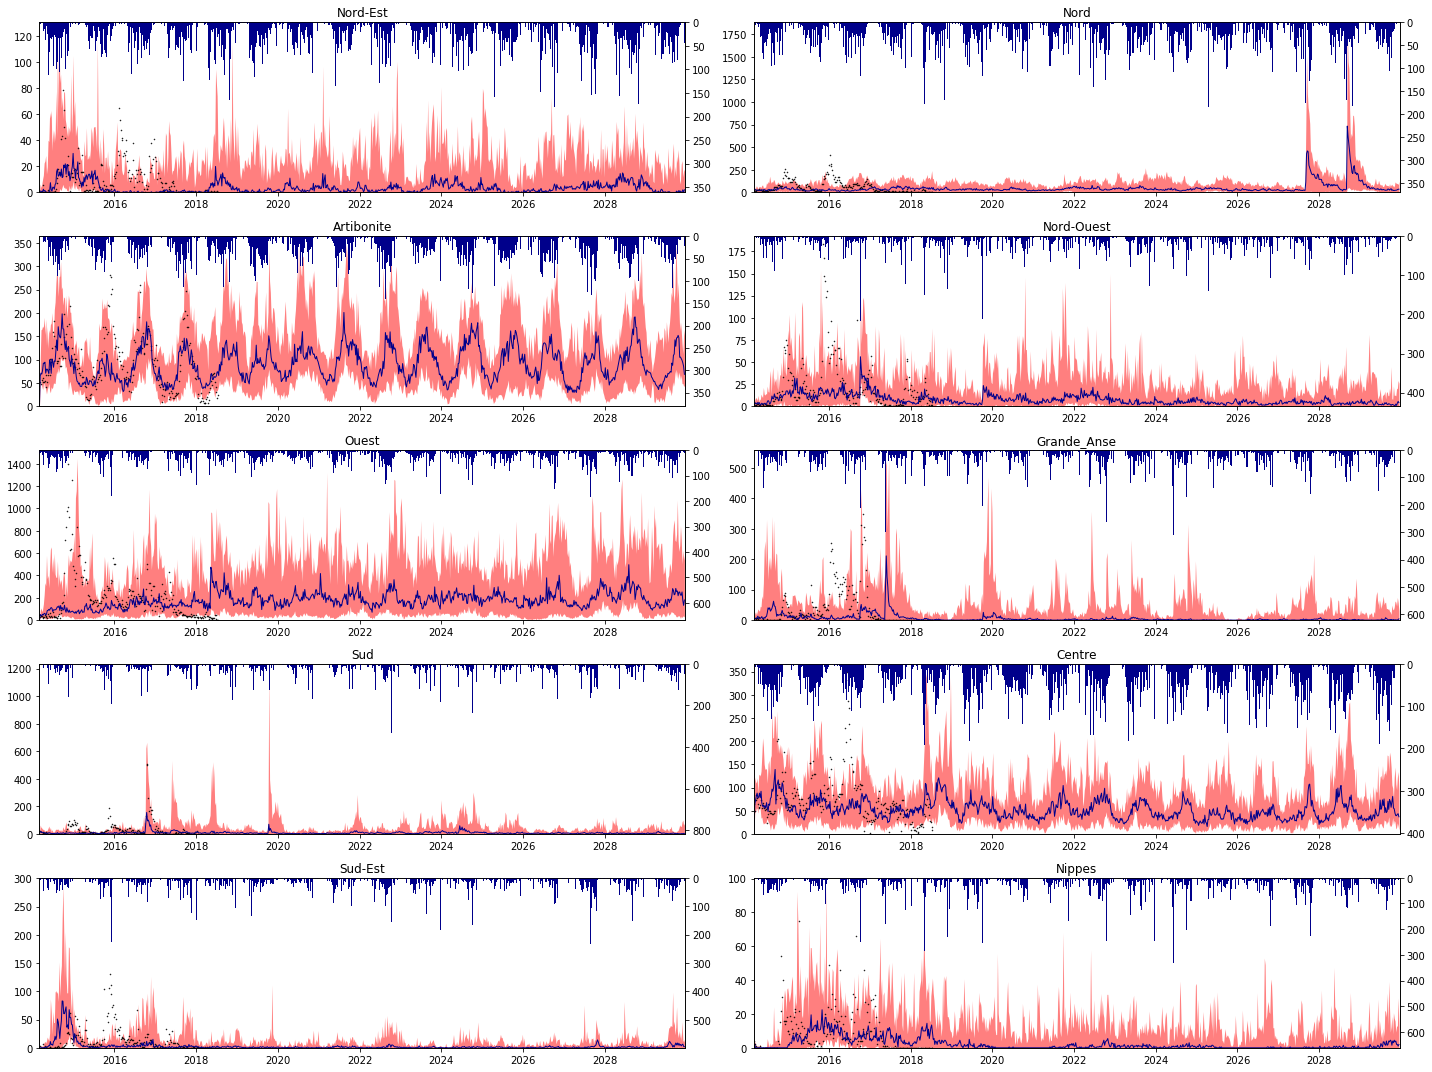

In [52]:
fig, axes = plt.subplots((len(all_data))//2, 2, figsize=(20,15), squeeze = True);
axes = axes.flatten();
for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][t_start:], marker='.', linestyle='-',color='k', linewidth=0, markersize=1 ) 
    axes[i].fill_between(all_data[dp]['cases']['q05'].index, all_data[dp]['cases']['q05'], all_data[dp]['cases']['q95'], alpha = .5, color = 'red', linewidth = 0)
    #axes[i].plot(all_data[dp]['cases']['mean'], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(all_data[dp]['cases']['q50'], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    axt.bar(pd.date_range(t_start,t_for, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[t_start:t_for], 
                label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(t_start, t_for)
    #axes[i].legend()
    
fig.tight_layout()

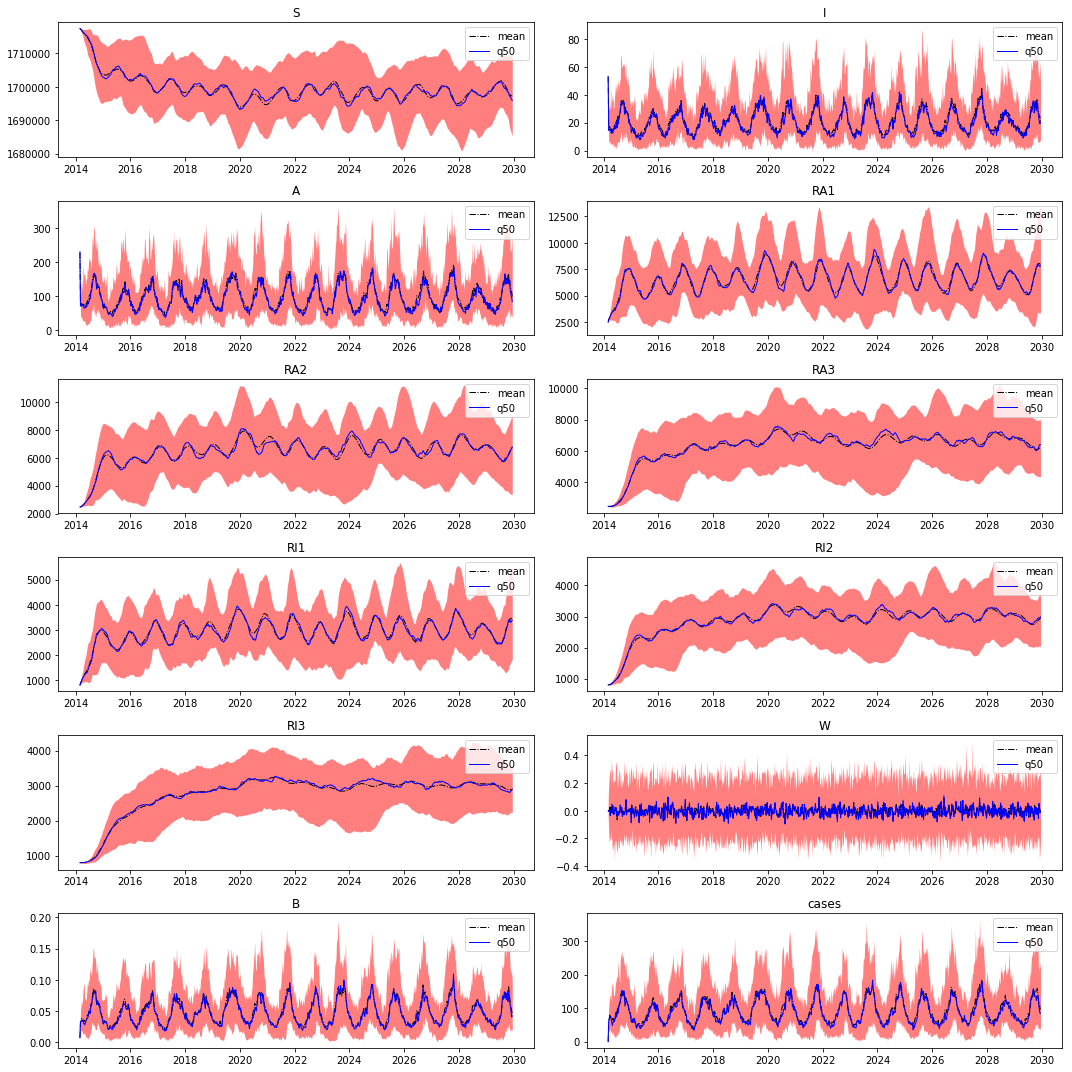

In [38]:
dp = 'Sud-Est'
fig, axes = plt.subplots((len(compartments))//2, 2, figsize=(15,15), squeeze = True);
axes = axes.flatten();
for i, comp in enumerate(compartments):
    axes[i].fill_between(all_data[dp][comp]['q05'].index, all_data[dp][comp]['q05'], all_data[dp][comp]['q95'], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data[dp][comp]['mean'], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(all_data[dp][comp]['q50'], alpha = 1,linestyle='-', linewidth = 1, color = 'blue') 
    axes[i].set_title(comp)
    axes[i].legend()
    
fig.tight_layout()

In [47]:
robjects.r('names(params)')

array(['sigma', 'betaB', 'mu_B', 'XthetaA', 'thetaI', 'gammaI', 'lambda',
       'lambdaR', 'r', 'rhoA', 'XrhoI', 'std_W', 'epsilon', 'k',
       'foi_add', 'gammaA', 'Rtot_0', 'H', 'D', 'mu', 'alpha', 'I_0',
       'A_0', 'B_0', 'RI1_0', 'RI2_0', 'RI3_0', 'RA1_0', 'RA2_0', 'RA3_0',
       'rhoI'], dtype='<U7')

In [39]:
r_names = robjects.r['names']


rpy2.rinterface.NULL

In [40]:
r_names = robjects.r['names']

In [43]:
a = r_names('best_params')

In [44]:
a

rpy2.rinterface.NULL